In [1]:
%load_ext autoreload
%autoreload 2

import os
import anndata as ad
import scanpy as sc
from scalex_mp import SCALEXLogic

In [2]:
src = "D:/2021-11_livecell_growth/adata"
adata_fn = "adata_final_fs.h5ad"
adata = ad.read_h5ad(os.path.join(src, adata_fn))
adata

AnnData object with n_obs × n_vars = 7661 × 420
    obs: 'ImageNumber', 'ObjectNumber', 'Metadata_Field', 'Metadata_FileLocation', 'Metadata_Frame', 'Metadata_Marker', 'Metadata_Series', 'Metadata_Time', 'Metadata_Well', 'Cells_Location_CenterMassIntensity_X_Cytoskeleton', 'Cells_Location_CenterMassIntensity_X_Mito', 'Cells_Location_CenterMassIntensity_Y_Cytoskeleton', 'Cells_Location_CenterMassIntensity_Y_Mito', 'Cells_Location_CenterMassIntensity_Z_Cytoskeleton', 'Cells_Location_CenterMassIntensity_Z_Mito', 'Cells_Location_Center_X', 'Cells_Location_Center_Y', 'Cells_Location_Center_Z', 'Cells_Location_MaxIntensity_X_Cytoskeleton', 'Cells_Location_MaxIntensity_X_Mito', 'Cells_Location_MaxIntensity_Y_Cytoskeleton', 'Cells_Location_MaxIntensity_Y_Mito', 'Cells_Location_MaxIntensity_Z_Cytoskeleton', 'Cells_Location_MaxIntensity_Z_Mito', 'Cells_Parent_Nuc_10', 'Cells_Parent_Primarieswithoutborder', 'Primarieswithoutborder_Location_CenterMassIntensity_X_DNA', 'Primarieswithoutborder_Locat

In [3]:
batch_var = 'PlateNumber'
treat_var = 'Metadata_Treatment'
time_var = 'Metadata_Time'

In [4]:
adata.obs[batch_var] = adata.obs[batch_var].astype('category')

In [10]:
sc.pp.neighbors(adata)
sc.tl.umap(adata)

C:\Users\amarx\Anaconda3\envs\scalex\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\amarx\Anaconda3\envs\scalex\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


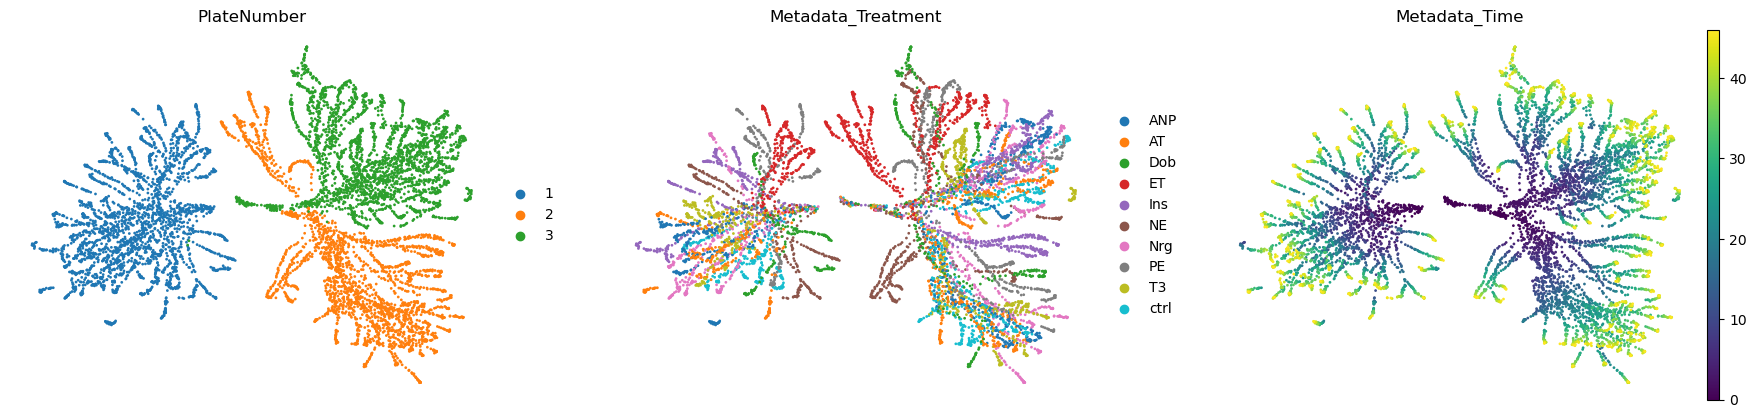

In [11]:
sc.pl.umap(adata, color=[batch_var, treat_var, time_var], frameon=False)

In [5]:
logic = SCALEXLogic(
    adata=adata,
    num_workers=0,
    beta=1,
    beta_norm=True,
    batch_key=batch_var
)

In [6]:
logic.fit(max_epochs=30, wandb_log=False)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name            | Type          | Params
--------------------------------------------------
0 | encoder         | VAEEncoder    | 453 K 
1 | decoder         | Decoder       | 7.1 K 
2 | recon_loss_func | MSELoss       | 0     
3 | regul_loss_func | KLDLoss       | 0     
4 | mmd             | DomainMMDLoss | 0     
--------------------------------------------------
460 K     Trainable params
0         Non-trainable params
460 K     Total params
1.843     Total estimated model params size (MB)
C:\Users\amarx\Anaconda3\envs\scalex\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:430: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataL

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


In [5]:
# load pretrained model
model_path = "./checkpoints/epoch=29_best_loss.ckpt"
# model_path = "./SCALEX/bxg3lhbb/checkpoints/epoch=29_best_loss.ckpt"
logic = SCALEXLogic.from_checkpoint(model_path, adata=adata, num_workers=0)

In [7]:
# show the model structure
logic.model

SCALEX(
  (encoder): VAEEncoder(
    (encode): Sequential(
      (0): Block(
        (fc): Linear(in_features=420, out_features=1024, bias=True)
        (norm_layer): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (act_layer): ReLU()
      )
    )
    (mu_encoder): Linear(in_features=1024, out_features=10, bias=True)
    (var_encoder): Linear(in_features=1024, out_features=10, bias=True)
  )
  (decoder): Decoder(
    (decode): ArgsSequential(
      (0): Block(
        (fc): Linear(in_features=10, out_features=420, bias=True)
        (norm_layer): DomainSpecificBatchNorm1d(
          (bns): ModuleList(
            (0): BatchNorm1d(420, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (1): BatchNorm1d(420, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): BatchNorm1d(420, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          )
        )
        (act_layer): Identity()


In [8]:
adata = logic.get_latent(return_mean=True)

Get latent: 100%|██████████| 120/120 [00:10<00:00, 10.99it/s]


In [9]:
sc.pp.neighbors(adata, use_rep='X_latent')
sc.tl.umap(adata)

C:\Users\amarx\Anaconda3\envs\scalex\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
C:\Users\amarx\Anaconda3\envs\scalex\lib\site-packages\scanpy\plotting\_tools\scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


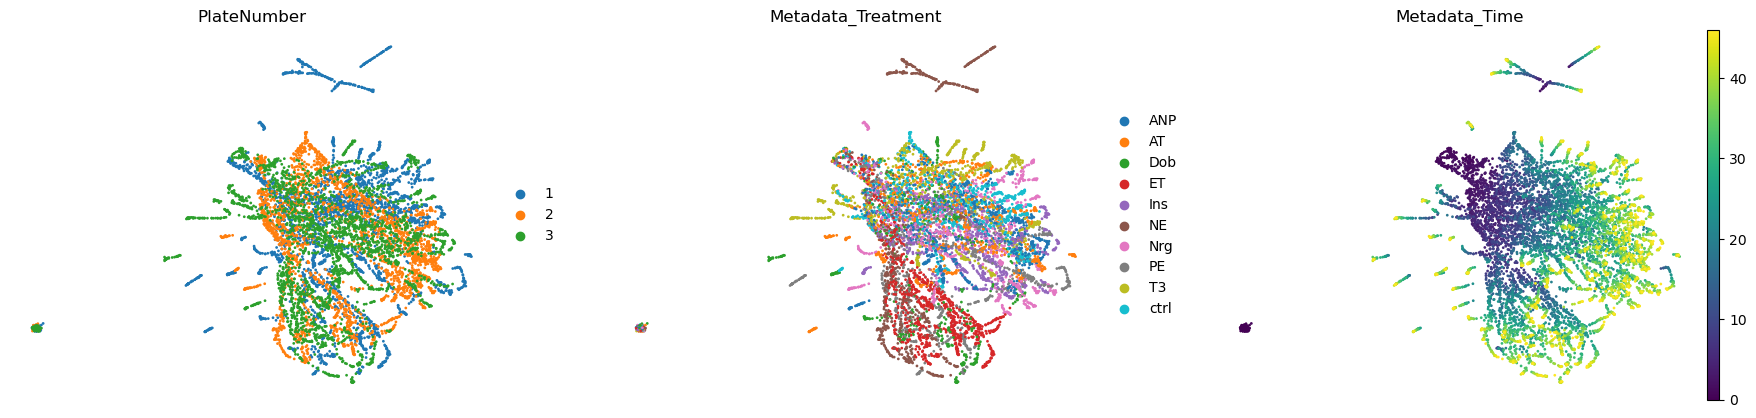

In [10]:
sc.pl.umap(adata, color=[batch_var, treat_var, time_var], frameon=False)
